In [1]:
# librerias

import warnings
warnings.filterwarnings('ignore')


import pylab as plt
import pandas as pd
import seaborn as sns


from keras.utils import get_file

from keras import Sequential
from keras.layers import Dense

from keras.callbacks import Callback, EarlyStopping

from tensorflow.keras.optimizers.legacy import RMSprop

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from datetime import date, time, datetime, timedelta

In [2]:
import numpy as np

# Preparación del dataset  
Las columnas tienen los siguientes significados:  
- status (Housing status - a. ready for sale or b. ready to build)
- bed (# of beds)
- bath (# of bathrooms)
- acre_lot (Property / Land size in acres)
- city (city name)
- state (state name)
- zip_code (postal code of the area)
- house_size (house area/size/living space in square feet)
- prev_sold_date (Previously sold date)
- price (Housing price, it is either the current listing price or recently sold price if the house is sold recently)

In [3]:
df_realtor = pd.read_csv('realtor-data.csv')

In [4]:
df_realtor.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [5]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512159 entries, 0 to 512158
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        512159 non-null  object 
 1   price         512159 non-null  float64
 2   bed           413222 non-null  float64
 3   bath          416941 non-null  float64
 4   acre_lot      407180 non-null  float64
 5   full_address  512159 non-null  object 
 6   street        511543 non-null  object 
 7   city          512100 non-null  object 
 8   state         512159 non-null  object 
 9   zip_code      511962 non-null  float64
 10  house_size    395693 non-null  float64
 11  sold_date     202507 non-null  object 
dtypes: float64(6), object(6)
memory usage: 46.9+ MB


Cambiamos la columna sold_date a formato fecha

In [6]:
df_realtor['sold_date'] = pd.to_datetime(df_realtor['sold_date'], format='%Y-%m-%d', errors='coerce')

Creamos una nueva columna con el año de venta

In [7]:
def anio(x):
    if pd.isna(x):
        return 0
    else:
        return x.year
df_realtor['sold_year'] = df_realtor['sold_date'].apply(anio)

Creamos una nueva columna con las estaciones del año

In [8]:
def estaciones(x):
    if pd.isna(x):
        return 'not sold'
    dia_mes = datetime(x.year, x.month, x.day)
    primavera = datetime(x.year, 3, 21)
    verano = datetime(x.year, 6, 21)
    otoño = datetime(x.year, 9, 21)
    invierno = datetime(x.year, 12, 21)
    if primavera <= dia_mes < verano:
        return 'spring'
    elif verano <= dia_mes < otoño:
        return 'summer'
    elif otoño <= dia_mes < invierno:
        return 'autumn'
    else:  
        return 'winter'

df_realtor['sold_season'] = df_realtor['sold_date'].apply(estaciones)


Eliminamos la columna date porque ya hemos extraído la información que nos interesaba

In [9]:
df_realtor.drop('sold_date', axis=1, inplace=True)

Vamos a eliminar las columnas full_address, street y city puesto que esa info es redundante con la información que nos ofrece la columna State

In [10]:
df_realtor.drop('full_address', axis=1, inplace=True)
df_realtor.drop('street', axis=1, inplace=True)
df_realtor.drop('city', axis=1, inplace=True)
df_realtor.drop('zip_code', axis=1, inplace=True)

In [11]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512159 entries, 0 to 512158
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   status       512159 non-null  object 
 1   price        512159 non-null  float64
 2   bed          413222 non-null  float64
 3   bath         416941 non-null  float64
 4   acre_lot     407180 non-null  float64
 5   state        512159 non-null  object 
 6   house_size   395693 non-null  float64
 7   sold_year    512159 non-null  int64  
 8   sold_season  512159 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 35.2+ MB


Eliminamos nulos

In [12]:
df_realtor.dropna(inplace=True)

Cambiamos las columnas de número de baños y habitaciones a números enteros

In [13]:
df_realtor['bed'] = df_realtor['bed'].astype(int)
df_realtor['bath'] = df_realtor['bath'].astype(int)

In [14]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294459 entries, 0 to 512158
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   status       294459 non-null  object 
 1   price        294459 non-null  float64
 2   bed          294459 non-null  int32  
 3   bath         294459 non-null  int32  
 4   acre_lot     294459 non-null  float64
 5   state        294459 non-null  object 
 6   house_size   294459 non-null  float64
 7   sold_year    294459 non-null  int64  
 8   sold_season  294459 non-null  object 
dtypes: float64(3), int32(2), int64(1), object(3)
memory usage: 20.2+ MB


Vemos como queda el dataset

In [15]:
df_realtor.head()

,status,price,bed,bath,acre_lot,state,house_size,sold_year,sold_season
0,for_sale,105000.0,3,2,0.12,Puerto Rico,920.0,0,not sold
1,for_sale,80000.0,4,2,0.08,Puerto Rico,1527.0,0,not sold
2,for_sale,67000.0,2,1,0.15,Puerto Rico,748.0,0,not sold
3,for_sale,145000.0,4,2,0.10,Puerto Rico,1800.0,0,not sold
5,for_sale,179000.0,4,3,0.46,Puerto Rico,2520.0,0,not sold


Vamos a observar las variables categóricas que nos quedan

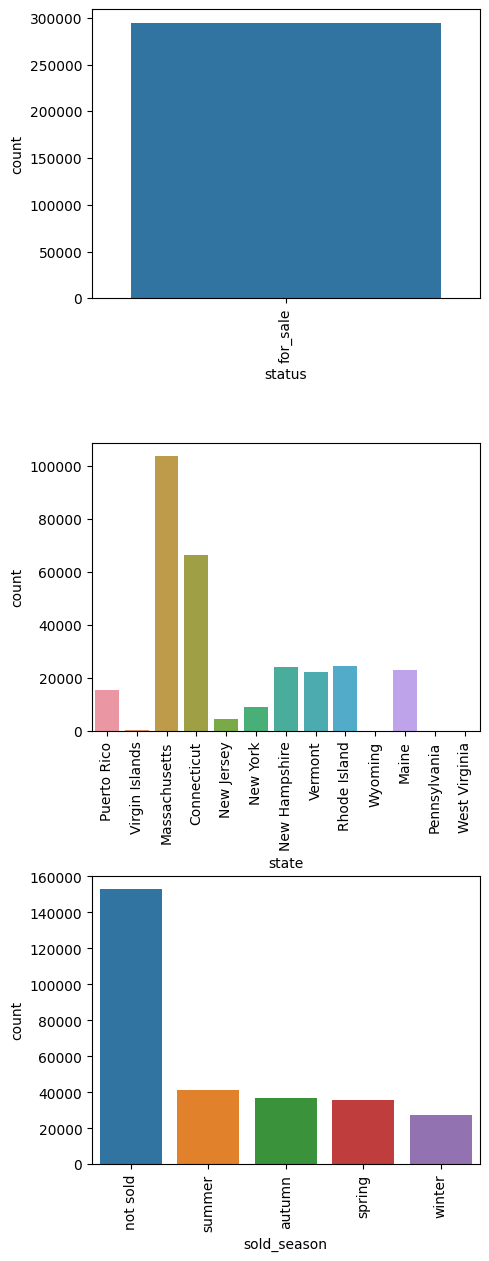

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,15))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(['status','state','sold_season']):
  sns.countplot(x=col, data=df_realtor, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

Eliminamos status, porque al eliminar todos los nulos, hemos eliminado las casas con la categoría ready to build.  
Esto significa que en EEUU no suelen venderse muchas casas sobre plano, es decir que no están construidas.

In [17]:
df_realtor.drop('status', axis=1, inplace=True)

In [18]:
df_realtor.state.value_counts()

state
Massachusetts     103770
Connecticut        66626
Rhode Island       24620
New Hampshire      24454
Maine              23010
Vermont            22205
Puerto Rico        15451
New York            9169
New Jersey          4796
Virgin Islands       342
Pennsylvania          12
Wyoming                3
West Virginia          1
Name: count, dtype: int64

Puerto Rico y las Islas Vírgenes están en el Caribe. Vamos a crear un nuevo valor que sea Caribbean States  
Pennsylvania, New Jersey y West Virginia son estados del Este que están muy próximos entre sí y tienen pocos valores. Los agrupamos bajo N.Jersey and nearby

In [19]:
def agrupacion(x):
    if x == 'Virgin Islands':
        return 'Caribbean states'
    elif x == 'Puerto Rico':
        return 'Caribbean states'
    elif x == 'New Jersey':
        return 'N.Jersey and nearby'
    elif x == 'Pennsylvania':
        return 'N.Jersey and nearby'
    elif x == 'West Virginia':
        return 'N.Jersey and nearby'
    else:
        return x
df_realtor['state']=df_realtor['state'].apply(agrupacion)

Eliminamos Wyoming porque apenas hay valores

In [20]:
df_realtor = df_realtor[~(df_realtor['state']=='Wyoming')]

Observamos las variables categóricas después de la limpieza

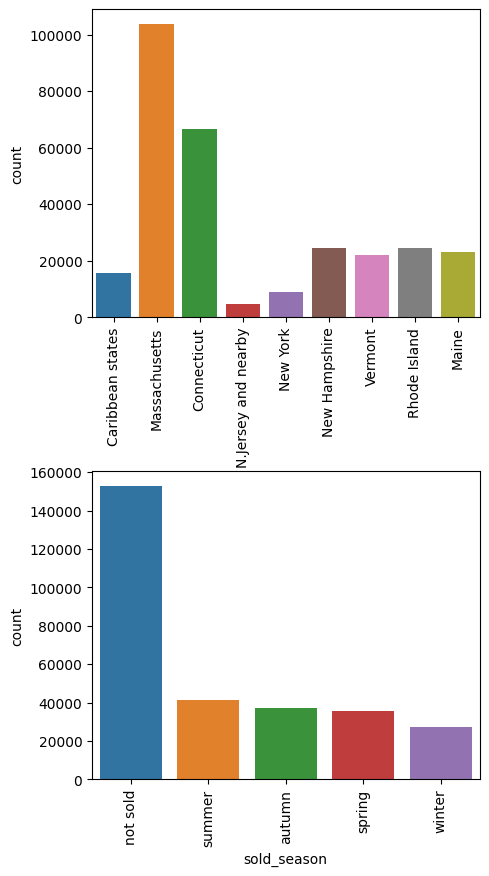

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(['state','sold_season']):
  sns.countplot(x=col, data=df_realtor, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

Vemos atípicos en variables numéricas

In [22]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294456 entries, 0 to 512158
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   price        294456 non-null  float64
 1   bed          294456 non-null  int32  
 2   bath         294456 non-null  int32  
 3   acre_lot     294456 non-null  float64
 4   state        294456 non-null  object 
 5   house_size   294456 non-null  float64
 6   sold_year    294456 non-null  int64  
 7   sold_season  294456 non-null  object 
dtypes: float64(3), int32(2), int64(1), object(2)
memory usage: 18.0+ MB


In [23]:
df_realtor.house_size.max()

1450112.0

In [24]:
df_realtor.house_size.min()

122.0

In [25]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294456 entries, 0 to 512158
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   price        294456 non-null  float64
 1   bed          294456 non-null  int32  
 2   bath         294456 non-null  int32  
 3   acre_lot     294456 non-null  float64
 4   state        294456 non-null  object 
 5   house_size   294456 non-null  float64
 6   sold_year    294456 non-null  int64  
 7   sold_season  294456 non-null  object 
dtypes: float64(3), int32(2), int64(1), object(2)
memory usage: 18.0+ MB


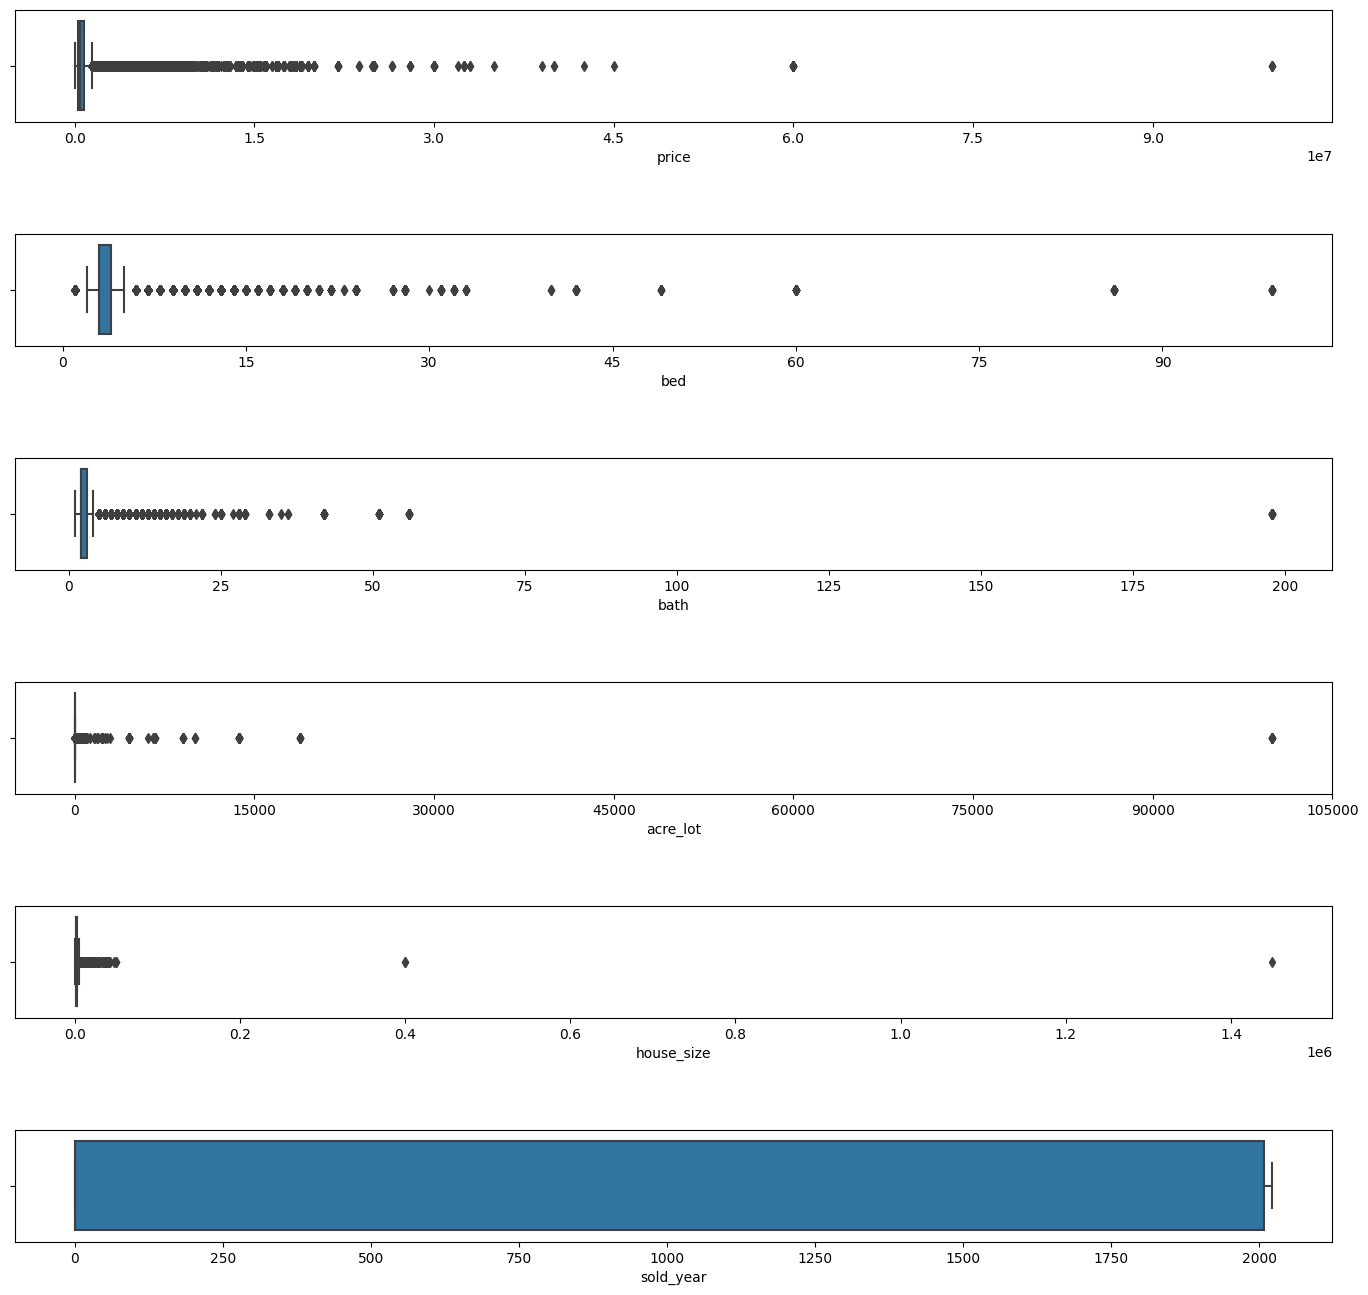

In [26]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # set a fixed number of ticks

Como vemos, hay muchos atípicos en la variable metros cuadrados. Esto puede deberse a que este dataset contiene propiedades muy grandes como mansiones, edificios enteros...  
También puede ser que haya errores tipográficos.  
Vamos a quitarnos las casas que tienen más baños que la media puesto que pueden tratarse de hoteles o edificios de oficinas y no de viviendas

In [27]:
print(f'Tamaño dataset anterior: {df_realtor.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_realtor[['bath']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_realtor = df_realtor[
    (df_realtor['bath']>=iqr_lim_inf) & (df_realtor['bath']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_realtor.shape}')

Tamaño dataset anterior: (294456, 8)
Tamaño dataset recortado: (268772, 8)


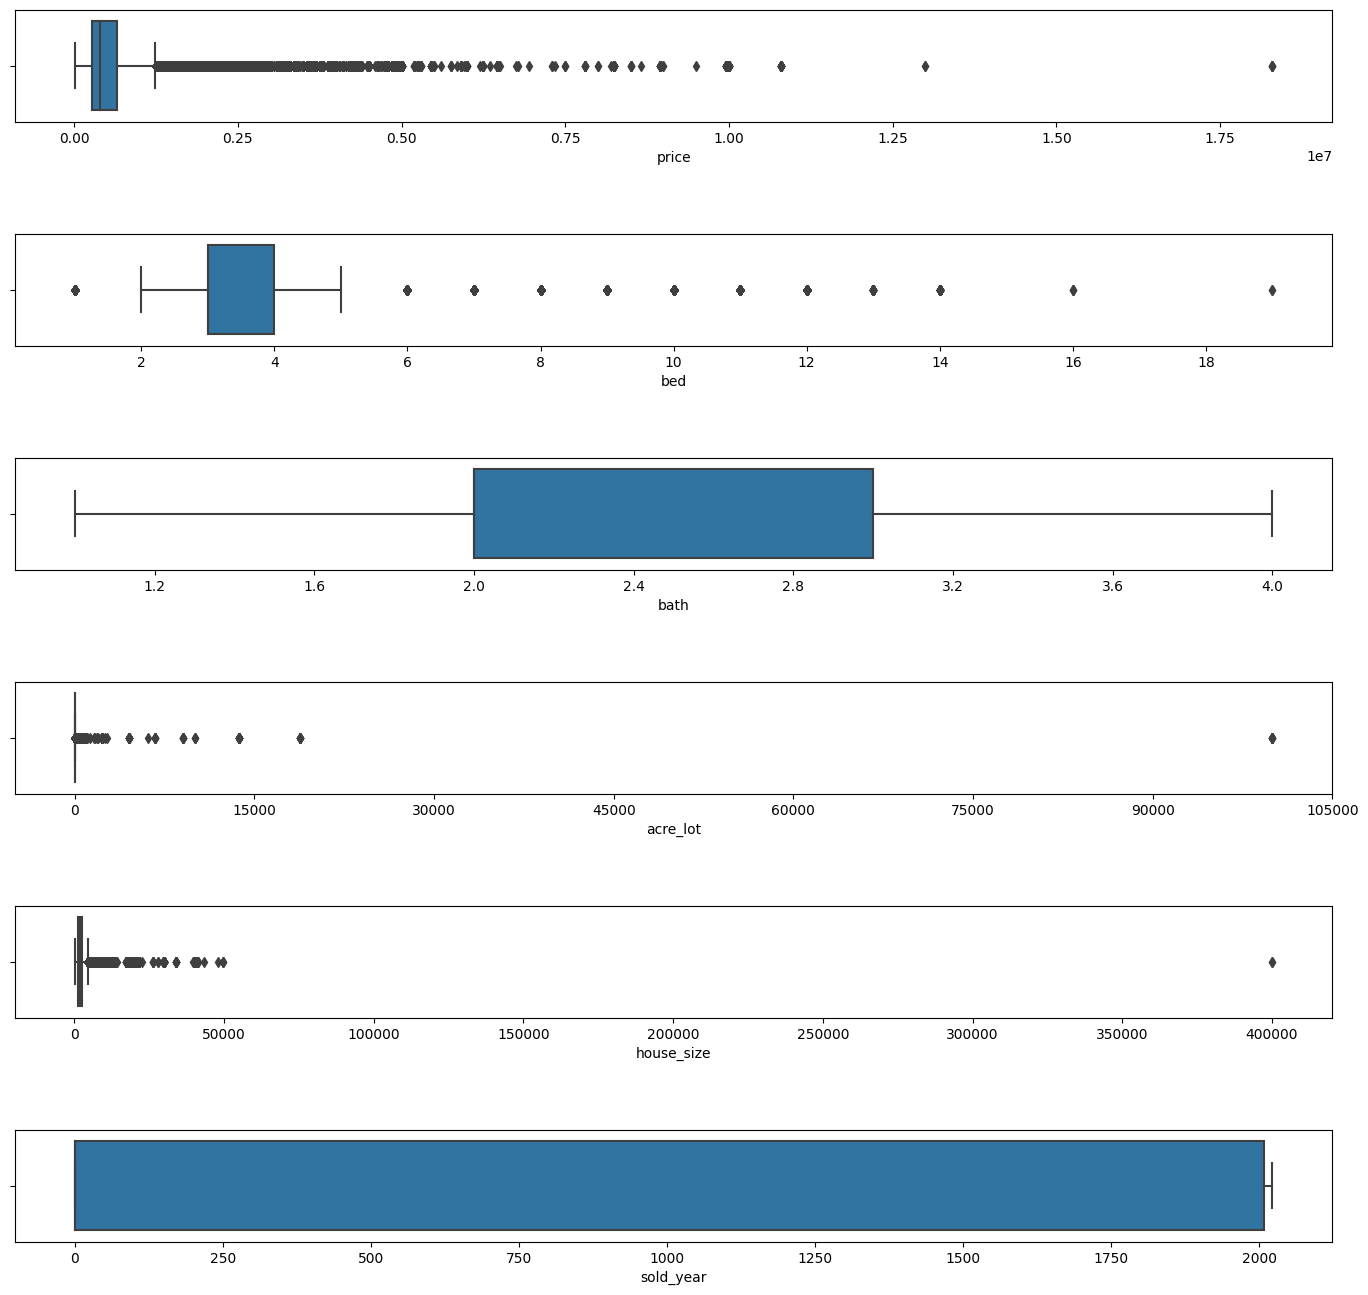

In [28]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # set a fixed number of ticks

Haremos lo mismo con las habitaciones. Aunque hayamos eliminado las propiedades con muchos baños, todavía nos quedan propiedades con demasiadas habitaciones.  
Pueden ser oficinas, hostales o pensiones con baños compartidos

In [29]:
print(f'Tamaño dataset anterior: {df_realtor.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_realtor[['bed']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_realtor = df_realtor[
    (df_realtor['bed']>=iqr_lim_inf) & (df_realtor['bed']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_realtor.shape}')

Tamaño dataset anterior: (268772, 8)
Tamaño dataset recortado: (238223, 8)


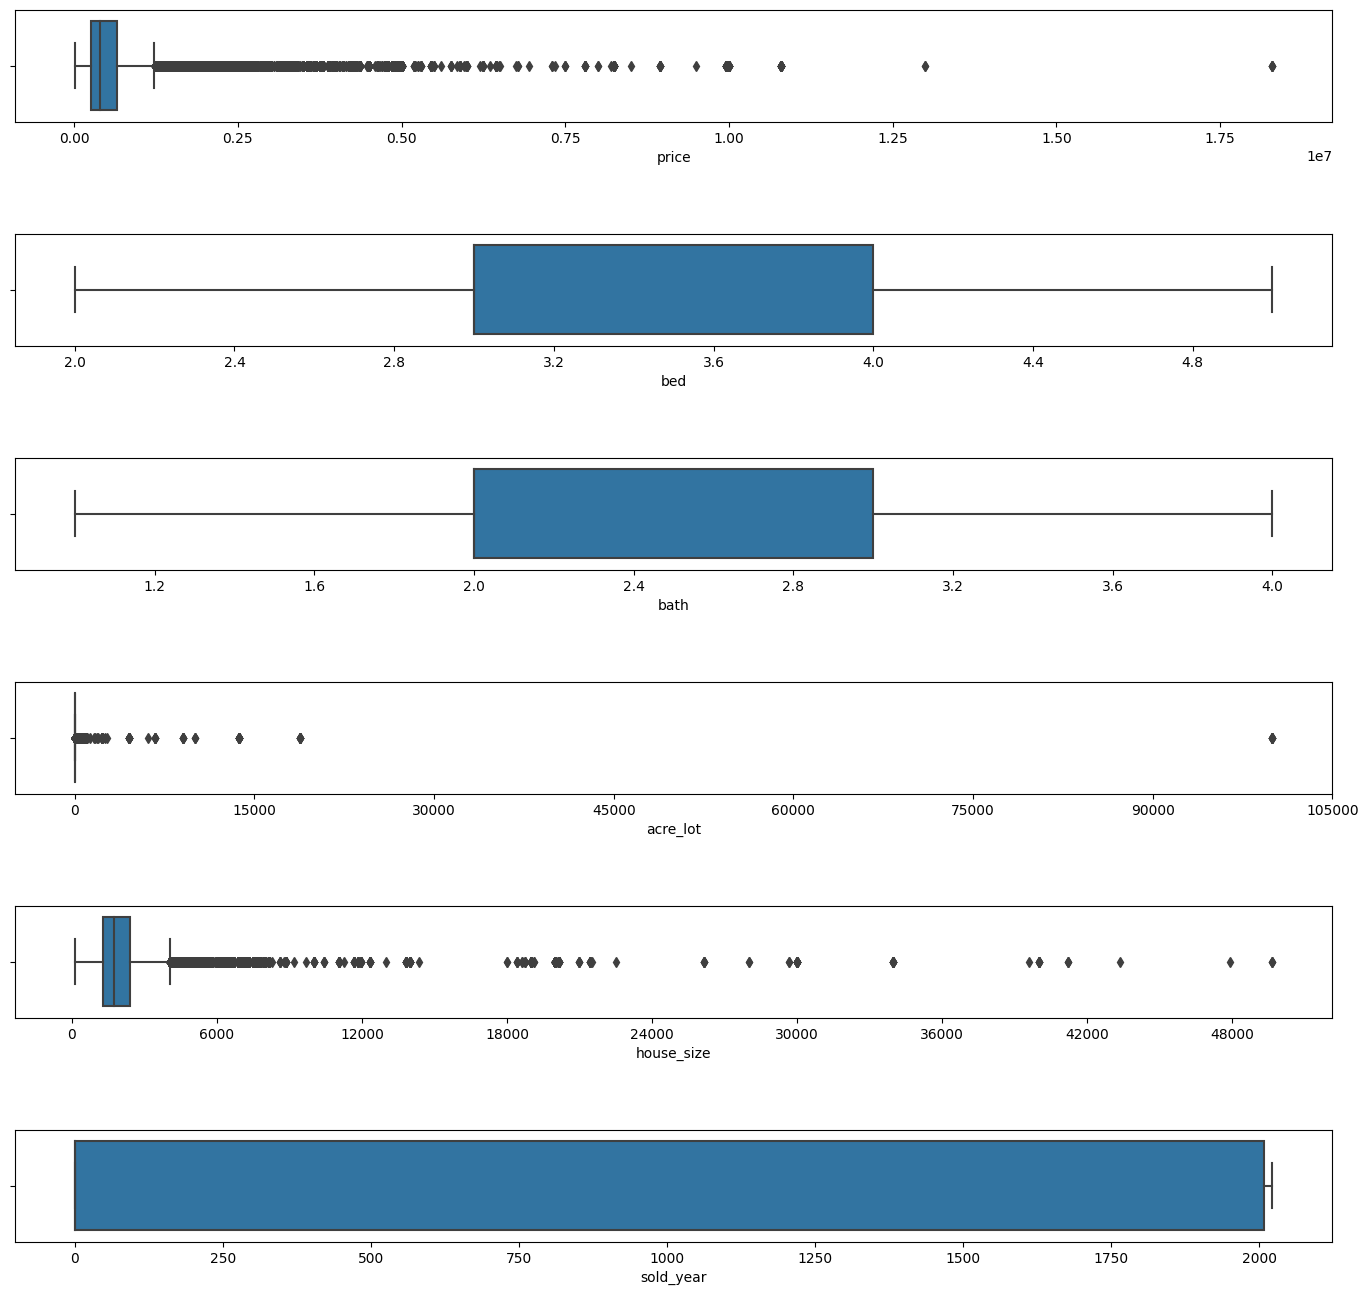

In [30]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # set a fixed number of ticks

Todavía nos quedan propiedades con muchos metros cuadrados que pueden tratarse de fincas o mansiones grandes. 
Para no quedarnos sin datos, Vamos a ajustar las dimensiones de las propiedades cuyo espacio constuido (house_size) y terreno (acre_lot), sea extremadamente grande.  
Además, ajustaremos el precio de las propiedades.

In [31]:
# Lista atípicos
listaatipicos = ['house_size','acre_lot','price']

#Creamos un bucle para recorrer la lista y corregir atípicos
for j in range (len(listaatipicos)):

#Con esta variable creamos un df solo con los los valores del atípico
        df_atipicos = df_realtor[[listaatipicos[j]]]

#Calculamos los cuartiles
        qs = df_atipicos.quantile([.25, .5, .75], numeric_only=True).values
        q1 = qs[0][0]
        q2 = qs[1][0]
        q3 = qs[2][0]

# Definimos los límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
        iqr = q3-q1
        iqr_lim_inf = round(q1 - 1.5*iqr)
        iqr_lim_sup = round(q3 + 1.5*iqr)

#Aquí le indicamos que cuando encuentre un valor superior al límite que hemos definido,que nos lo reemplace por el valor asignado al límite superior y viceversa
        df_realtor[listaatipicos[j]] = df_realtor[listaatipicos[j]].apply(
        lambda x: iqr_lim_sup if x > iqr_lim_sup else (iqr_lim_inf if x < iqr_lim_inf else x))

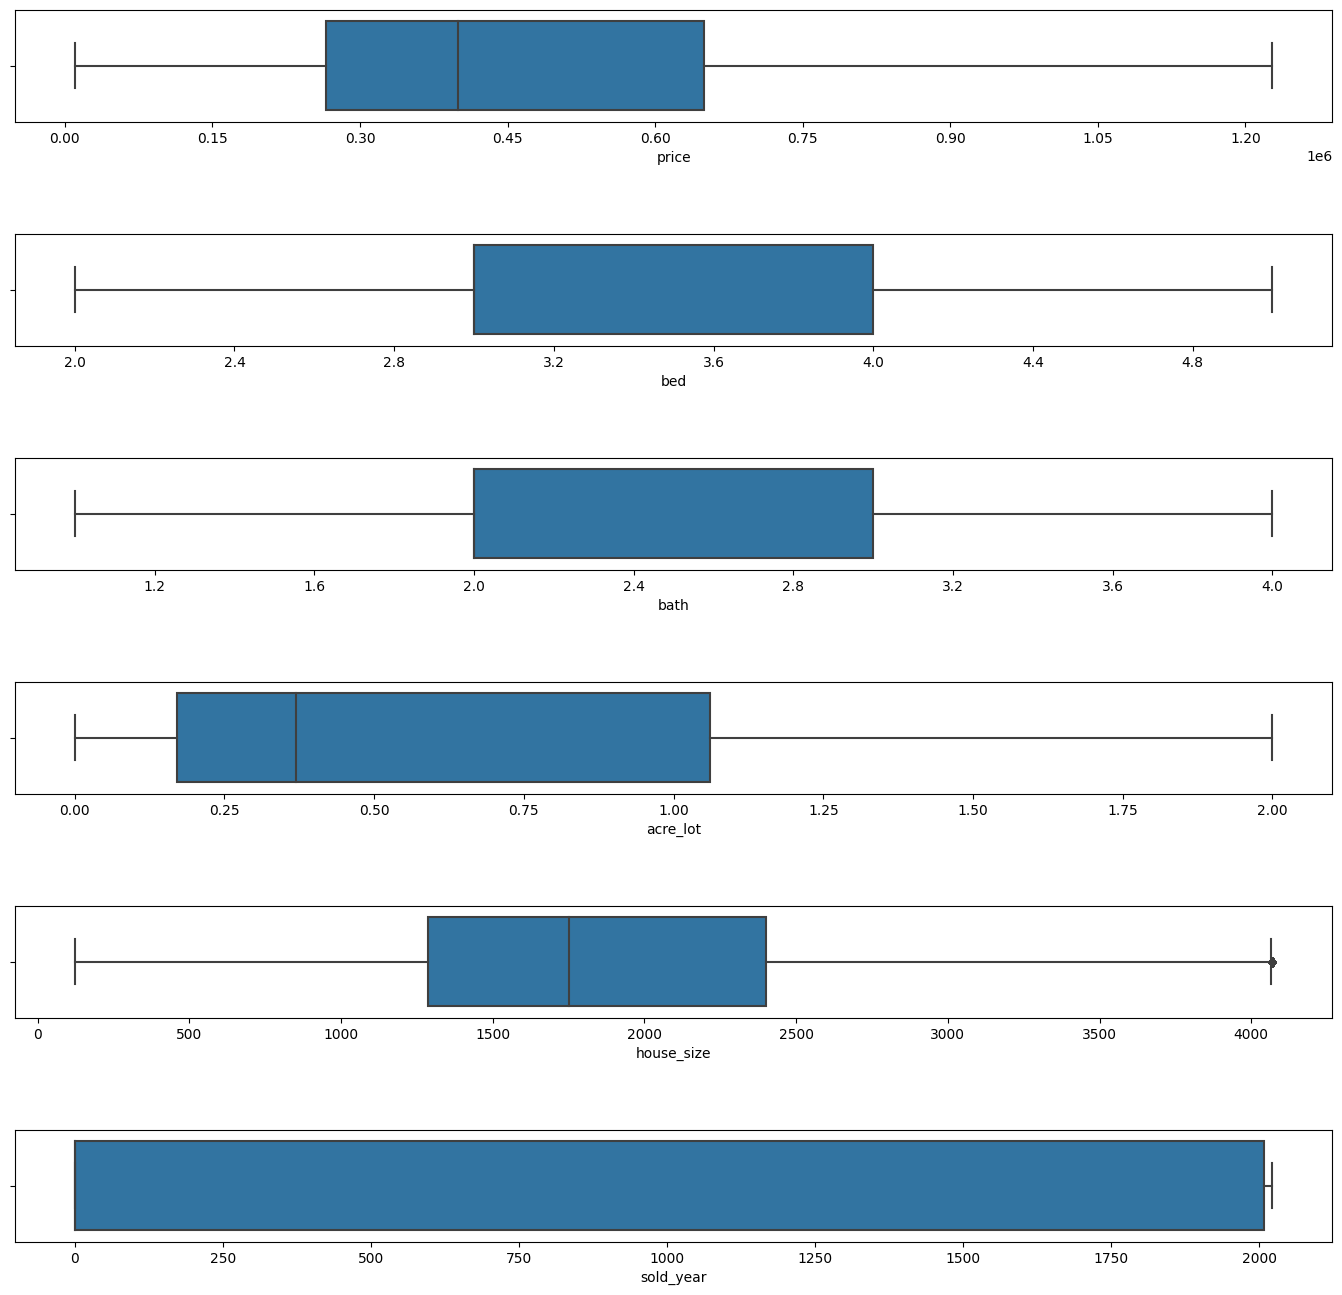

In [32]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) 

Convertimos las variables categóricas a Dummies

In [33]:
df_realtor = pd.get_dummies(df_realtor, columns=['sold_season'])

In [34]:
nombres_antiguos = list(df_realtor.columns[7:13])
nombres_nuevos = []
for i in range(len(nombres_antiguos)):
    nombres_nuevos.append((nombres_antiguos[i])[12:(len(nombres_antiguos[i]))])
cambio_nombres = {}
for i in range(len(nombres_antiguos)):
    cambio_nombres[nombres_antiguos[i]] = nombres_nuevos[i]
df_realtor.rename(columns = cambio_nombres, inplace=True)

In [35]:
df_realtor

,price,bed,bath,acre_lot,state,house_size,sold_year,autumn,not sold,spring,summer,winter
0,105000.0,3,2,0.12,Caribbean states,920.0,0,False,True,False,False,False
1,80000.0,4,2,0.08,Caribbean states,1527.0,0,False,True,False,False,False
2,67000.0,2,1,0.15,Caribbean states,748.0,0,False,True,False,False,False
3,145000.0,4,2,0.10,Caribbean states,1800.0,0,False,True,False,False,False
5,179000.0,4,3,0.46,Caribbean states,2520.0,0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
512130,785000.0,3,3,0.11,New York,1920.0,2004,True,False,False,False,False
512134,929000.0,3,3,0.06,New York,1873.0,1990,False,False,False,True,False
512146,990000.0,5,3,0.07,New York,2800.0,0,False,True,False,False,False
512149,1227500.0,5,3,0.05,New York,2064.0,1983,True,False,False,False,False


In [36]:
df_realtor = pd.get_dummies(df_realtor, columns=['state'])

In [37]:
nombres_antiguos = list(df_realtor.columns[11:20])
nombres_nuevos = []
for i in range(len(nombres_antiguos)):
    nombres_nuevos.append((nombres_antiguos[i])[6:(len(nombres_antiguos[i]))])
cambio_nombres = {}
for i in range(len(nombres_antiguos)):
    cambio_nombres[nombres_antiguos[i]] = nombres_nuevos[i]
df_realtor.rename(columns = cambio_nombres, inplace=True)

In [38]:
df_realtor

,price,bed,bath,acre_lot,house_size,sold_year,autumn,not sold,spring,summer,winter,Caribbean states,Connecticut,Maine,Massachusetts,N.Jersey and nearby,New Hampshire,New York,Rhode Island,Vermont
0,105000.0,3,2,0.12,920.0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False
1,80000.0,4,2,0.08,1527.0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False
2,67000.0,2,1,0.15,748.0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False
3,145000.0,4,2,0.10,1800.0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False
5,179000.0,4,3,0.46,2520.0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512130,785000.0,3,3,0.11,1920.0,2004,True,False,False,False,False,False,False,False,False,False,False,True,False,False
512134,929000.0,3,3,0.06,1873.0,1990,False,False,False,True,False,False,False,False,False,False,False,True,False,False
512146,990000.0,5,3,0.07,2800.0,0,False,True,False,False,False,False,False,False,False,False,False,True,False,False
512149,1227500.0,5,3,0.05,2064.0,1983,True,False,False,False,False,False,False,False,False,False,False,True,False,False


In [39]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238223 entries, 0 to 512154
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                238223 non-null  float64
 1   bed                  238223 non-null  int32  
 2   bath                 238223 non-null  int32  
 3   acre_lot             238223 non-null  float64
 4   house_size           238223 non-null  float64
 5   sold_year            238223 non-null  int64  
 6   autumn               238223 non-null  bool   
 7   not sold             238223 non-null  bool   
 8   spring               238223 non-null  bool   
 9   summer               238223 non-null  bool   
 10  winter               238223 non-null  bool   
 11  Caribbean states     238223 non-null  bool   
 12  Connecticut          238223 non-null  bool   
 13  Maine                238223 non-null  bool   
 14  Massachusetts        238223 non-null  bool   
 15  N.Jersey and nearby  2